Hyrbid Importance Sampling with Markov Chains For Monte Crlo Integration

In [1]:
import nbimporter

from Importance_Int import importance_integration, target_pdf

#==============================Dependencies================================

#libraries
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, truncnorm
from numpy.random import Generator, MT19937
import time
from scipy.special import logsumexp

#Initializing the random number generator
seed = int(time.time()) 
bitgen = MT19937(seed)
rng = Generator(bitgen)  # reproducible generator

In [2]:
#=======================Metropolis-Hastings Algorithm (Python)========================
def metropolis_python(f, N, x0, step_size, burnin, thinning, rng=None):
    if rng is None:
        rng = np.random.default_rng()

    total_steps = N * thinning + burnin
    samples = []
    x = x0
    count = 0

    for i in range(total_steps):
        x_cand = x + rng.uniform(-step_size, step_size)
        alpha = min(1.0, abs(f(x_cand) / f(x)))
        if rng.uniform() < alpha:
            x = x_cand
            count += 1
        if i >= burnin and (i - burnin) % thinning == 0:
            samples.append(x)
    acceptance_rate = count / total_steps
    return np.array(samples)

In [3]:
#=======================Kernel Density Estimation (KDE) Functions========================

# Fixed-bandwidth KDE
def pilot_kde(samples, bandwidth): #fixed KDE mthod
    """Fixed-bandwidth KDE using Gaussian kernel."""
    def kde_eval(x_eval):
        x_eval = np.atleast_1d(x_eval)
        n = len(samples)
        coeff = 1 / (n * bandwidth * np.sqrt(2 * np.pi))
        diffs = (x_eval[:, None] - samples[None, :]) / bandwidth
        return coeff * np.sum(np.exp(-0.5 * diffs**2), axis=1)
    return kde_eval

def silverman_bandwidth(samples):
    n = len(samples)
    std = np.std(samples, ddof=1)
    return 1.06 * std * n ** (-1/5)

# Adaptive-bandwidth KDE
def adaptive_kde(samples, h_fixed, alpha=0.5): # Adative KDE method
    """
    Adaptive KDE using Abramson's square-root law.
    samples : 1D array of data points
    h_fixed : base bandwidth for pilot KDE
    alpha   : sensitivity parameter (default 0.5)
    """
    n = len(samples)

    # Step 1: pilot density estimate
    pilot = pilot_kde(samples, h_fixed)
    f_i = pilot(samples)

    # Step 2: compute geometric mean of pilot estimates
    g = np.exp(np.mean(np.log(f_i)))

    # Step 3: compute local bandwidth factors
    lambda_i = (f_i / g)**(-alpha)
    h_i = h_fixed * lambda_i

    # Step 4: adaptive KDE function
    def kde_adaptive(x_eval):
        x_eval = np.atleast_1d(x_eval)
        coeffs = 1 / (np.sqrt(2 * np.pi) * h_i)
        diffs = (x_eval[:, None] - samples[None, :]) / h_i
        result = np.sum(coeffs * np.exp(-0.5 * diffs**2), axis=1) / n
        return result

    return kde_adaptive

In [4]:
def hybrid_importance_sampling(f, m_chain, target_pdf):
    """
    Estimate the integral of f using importance sampling from KDE-estimated proposal.

    Returns:
        estimate: Monte Carlo estimate of the integral
        stderr: Standard error of the estimate (not just std of weights)
    """
    weights = f(m_chain) / target_pdf(m_chain)
    estimate = np.mean(weights)

    return estimate


In [5]:
def f(x):
    return np.exp(-x**2)

step_size=3
N_list = np.logspace(1, 4, num=50, dtype=int)#[5_000, 6000, 7000, 8000, 9000, 10_000, 12500, 15000, 20_000, 25000, 30000, 35000, 40_000]
hybrid_results = []
importance_results = []

for N in N_list:
    m_chain_hybrid = metropolis_python(f, N, rng.uniform(-10, 10), step_size, 2000, 10)
    h_fixed = silverman_bandwidth(m_chain_hybrid)
    kde = adaptive_kde(m_chain_hybrid, h_fixed, alpha=0.05)
    hybrid_estimate = hybrid_importance_sampling(f, m_chain_hybrid, kde)
    m_chain_importance = metropolis_python(f, N, rng.uniform(-10, 10), step_size, 2000, 10)
    importance_estimate = importance_integration(N, m_chain_importance)
    hybrid_results.append(hybrid_estimate)
    importance_results.append(importance_estimate)


hybrid_results = np.array(hybrid_results)
importance_results = np.array(importance_results)



TypeError: importance_integration() missing 2 required positional arguments: 'rng' and 'm_chain'

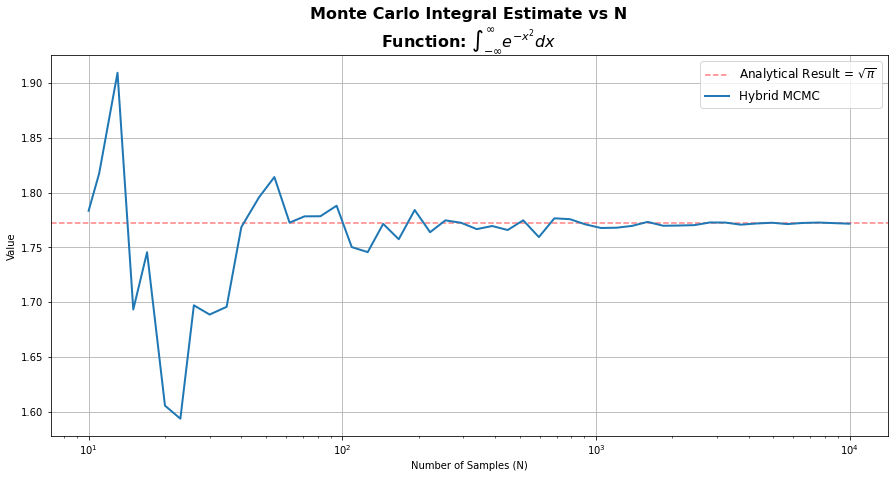

In [ ]:
plt.rcParams.update({'axes.titlesize': 16, 'axes.titleweight': 'bold', 'axes.titlepad': -20})

# Plot estimates with error bars
plt.figure(figsize=(15, 7))
plt.errorbar(N_list, hybrid_results, label='Hybrid MCMC', linewidth=2)

analytical_result = np.sqrt(np.pi)
plt.axhline(y=analytical_result, color='red', linestyle='--', label=r'Analytical Result = $\sqrt{\pi}$', alpha=0.5)
plt.xscale('log')
plt.xlabel('Number of Samples (N)')
plt.ylabel('Value')
function_description = r"$\int_{-\infty}^{\infty}e^{-x^2}dx$"  # Update the function description with infinity symbol
plt.title(f'Monte Carlo Integral Estimate vs N\nFunction: {function_description}', fontsize=16)
plt.legend(fontsize=12, loc='best')
plt.grid(True)
plt.savefig(f"plots/'Monte_Carlo_Integral_Estimate_vs_N_Function_{function_description}_step={step_size}.pdf", format="pdf")
plt.show()

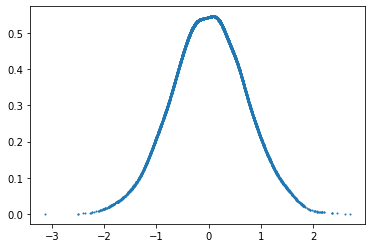

Hybrid Importance Sampling Estimate:


1.7729889151048626

In [ ]:
#========================Example Usage of Hybrid Importance Sampling========================
N=10000
m_chain = metropolis_python(f, N, rng.uniform(-10, 10), 6, 2000, 10)
h_fixed = silverman_bandwidth(m_chain)
kde = adaptive_kde(m_chain, h_fixed, alpha=0.05)

plt.plot(m_chain, kde(m_chain), 'o', markersize=1, label='KDE Samples')
plt.show()

print("Hybrid Importance Sampling Estimate:"),
hybrid_importance_sampling(f, m_chain, kde)

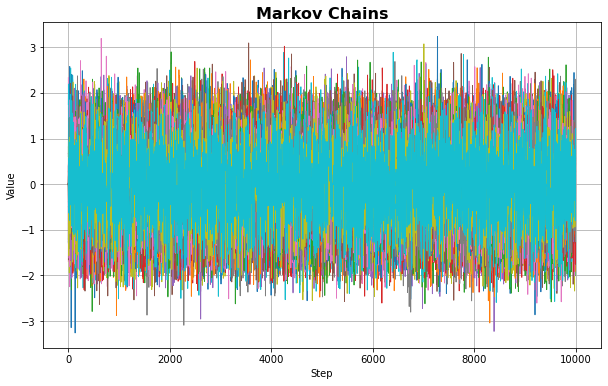

In [ ]:
# Generate a Markov chain using the Metropolis-Hastings algorithm
N = 10000
plt.figure(figsize=(10, 6))
for i in range(50):
    m_chain = metropolis_python(f, N, 0, 3, 0, 1)

    # Plot the Markov chain against its length
    #plt.figure(figsize=(10, 6))
    plt.plot(range(len(m_chain)), m_chain, label="Markov Chain", linewidth=0.85)
plt.xlabel("Step")
plt.ylabel("Value")
plt.title("Markov Chains")
#plt.legend()
plt.grid()
plt.savefig("Plots/markov_chain_plot_fast_mix.pdf")
plt.show()